In [9]:
import os
from Data.DatabaseConnection import DatabaseConnection
import pandas as pd

In [3]:
dotenv_path = os.path.abspath("../.env")  
db = DatabaseConnection(dotenv_path)

# Basic match analysis 

In [13]:
matches = db.get_all_matches()
df = pd.DataFrame(matches, columns=['match_id', 'game_datetime', 'game_length', 'map_id', 'tft_set_number'])
df['datetime'] = pd.to_datetime(df['game_datetime'], unit='ms')
df['game_length_min'] = df['game_length'] / 60
df.head()

,match_id,game_datetime,game_length,map_id,tft_set_number,datetime,game_length_min
0,EUN1_3778549380,1746732492440,2283.736816,22,14,2025-05-08 19:28:12.440,38.062280
1,EUN1_3785215189,1748180709057,1945.732422,22,14,2025-05-25 13:45:09.057,32.428874
2,EUN1_3782117290,1747503305415,1255.649292,22,14,2025-05-17 17:35:05.415,20.927488
3,EUN1_3783607953,1747829872691,2180.702881,22,14,2025-05-21 12:17:52.691,36.345048
4,EUN1_3774992073,1745959458563,2183.478027,22,14,2025-04-29 20:44:18.563,36.391300


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1000x1000 with 0 Axes>

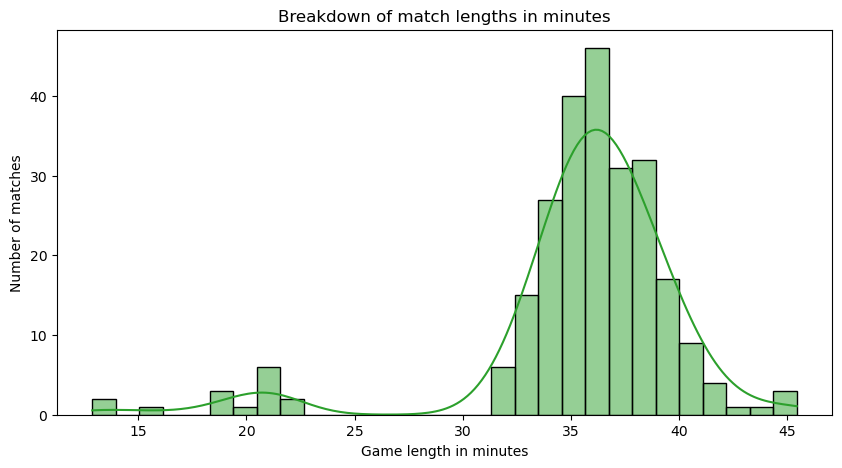

In [19]:
plt.figure(figsize=(10, 10))
plt.figure(figsize=(10, 5))
sns.histplot(df['game_length_min'], bins=30, kde=True, color="#2ca02c")
plt.title('Breakdown of match lengths in minutes')
plt.xlabel('Game length in minutes')
plt.ylabel('Number of matches')
plt.show()

In [20]:
players = db.get_all_players()
df_players = pd.DataFrame(players, columns=[
    'puuid', 'match_id', 'placement', 'level', 'gold_left', 'last_round', 'players_eliminated',
    'time_eliminated', 'total_damage', 'companion_id', 'tier', 'division', 'leaguePoints', 'wins', 'losses'
])
df_players.head()

,puuid,match_id,placement,level,gold_left,last_round,players_eliminated,time_eliminated,total_damage,companion_id,tier,division,leaguePoints,wins,losses
0,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,EUN1_3778549380,3,9,1,38,0,2177.756592,157,d401983f-04c9-4809-a1f4-d995a9ab6091,BRONZE,III,93,3,2
1,Ud8sd5s8jE_5bpv4rpb0-BRvayXhHJXKbi0eB1jue8iJxO...,EUN1_3778549380,5,8,30,33,0,1909.064697,68,05e285f5-7d09-4126-9643-da31b1bd2193,BRONZE,II,84,8,15
2,DdLDFxWyhuQTyuZMhQJaL4ZWS5ymGEa0BTgIvXXYS9u53x...,EUN1_3778549380,2,9,1,40,2,2270.521240,184,96c29152-c710-4f05-85c0-32eb73bef7c0,GOLD,IV,76,30,33
3,r6sJI0-vHg3NbXZ5rv92BM342jeKGm2oFpIzNQUAneQkic...,EUN1_3778549380,6,7,3,28,0,1647.791016,65,f152e2a3-6751-42e5-a911-ef029d5a8bff,SILVER,III,86,20,29
4,x0Ze-ORBYyEFKumY3rTDvSORTwnZTM9xnXUECY3Thm3hWV...,EUN1_3778549380,1,10,4,40,3,2270.521240,187,27f5bf5a-7183-4efa-b065-86ff9b8c0fb1,PLATINUM,II,57,33,19


In [199]:
tier_hierarchy = {
    "IRON": 0,
    "BRONZE": 1,
    "SILVER": 2,
    "GOLD": 3,
    "PLATINUM": 4,
    "EMERALD": 5,
    "DIAMOND": 6
}

tier_order = ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "EMERALD", "DIAMOND"]

tier_colors = {    
    "IRON": "#7f7f7f",
    "BRONZE": "#cd7f32",
    "SILVER": "#c0c0c0",
    "GOLD": "#ffd700",
    "PLATINUM": "#00bfff",
    "EMERALD": "#50c878",
    "DIAMOND": "#b9f2ff"
}

In [31]:
#for every player we are assigning a value which will be used to establish match rank 
df_players['tier_rank'] = df_players['tier'].map(tier_hierarchy)
print(df_players['tier_rank'].value_counts().sort_values(ascending=False))

tier_rank
3.0    370
2.0    357
4.0    302
5.0    225
6.0    198
1.0    139
0.0     46
Name: count, dtype: int64


How many players we have in each division. 

In [40]:
match_tiers_counts = df_players.groupby(['match_id', 'tier']).size().reset_index(name='player_count')
match_tiers_counts['tier_rank'] = match_tiers_counts['tier'].map(tier_hierarchy)
match_tiers_counts.head(10)

,match_id,tier,player_count,tier_rank
0,EUN1_3763831518,BRONZE,1,1.0
1,EUN1_3763831518,GOLD,3,3.0
2,EUN1_3763831518,IRON,1,0.0
3,EUN1_3763831518,PLATINUM,1,4.0
4,EUN1_3763831518,UNRANKED,2,NaN
5,EUN1_3764074771,BRONZE,2,1.0
6,EUN1_3764074771,EMERALD,1,5.0
7,EUN1_3764074771,GOLD,1,3.0
8,EUN1_3764074771,PLATINUM,2,4.0
9,EUN1_3764074771,SILVER,2,2.0


In [37]:
def assign_match_tier(match_id):
    match_data = match_tiers_counts[match_tiers_counts['match_id'] == match_id]
    
    if match_data.empty:
        return None
    
    # deleting match if rank is unidentified 
    match_data = match_data.dropna(subset=['tier_rank'])
    
    if match_data.empty:
        return None
    
    # found most common tiers (ranks - from IRON to DIAMOND).
    max_count = match_data['player_count'].max()
    # selecting only most common tiers which appeared in this particular match 
    dominant_tiers = match_data[match_data['player_count'] == max_count]
    
    # choosing dominant tier or selecting the lowest one from a dominant group of tiers 
    if len(dominant_tiers) == 1:
        lowest_tier = dominant_tiers.iloc[0]['tier']
    else:
        min_rank_idx = dominant_tiers['tier_rank'].idxmin() # idxmin() - return min index from available values
        lowest_tier = dominant_tiers.loc[min_rank_idx, 'tier']
    
    return lowest_tier

In [38]:
# assigning match_tier value to all unique matches
unique_matches = df_players['match_id'].unique()
match_tiers = []

for match_id in unique_matches:
    tier = assign_match_tier(match_id)
    match_tiers.append({'match_id': match_id, 'match_tier': tier})
    
match_tiers_df = pd.DataFrame(match_tiers)
match_tiers_df.head()

,match_id,match_tier
0,EUN1_3778549380,BRONZE
1,EUN1_3785215189,BRONZE
2,EUN1_3782117290,IRON
3,EUN1_3783607953,BRONZE
4,EUN1_3774992073,GOLD


In [42]:
df_merged = df.merge(match_tiers_df, on='match_id')
print(df_merged['match_tier'].value_counts())

match_tier
SILVER      64
GOLD        54
PLATINUM    40
DIAMOND     31
EMERALD     27
BRONZE      25
IRON         6
Name: count, dtype: int64


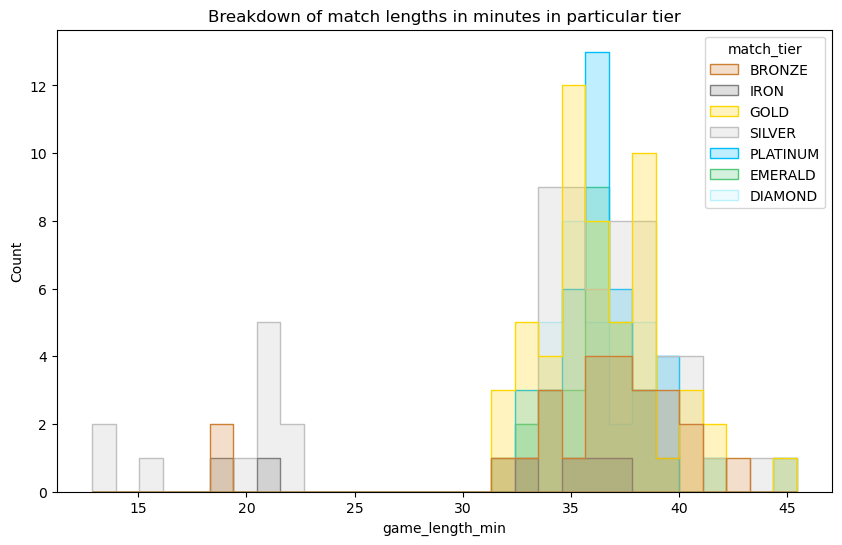

In [202]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df_merged, 
             x="game_length_min",
             hue="match_tier",
             element="step",
             stat="count",
             bins=30, 
             palette=tier_colors,
             # kde=True
             )

plt.title('Breakdown of match lengths in minutes in particular tier')
plt.show()

As we can observe there is a trend. After 10 min players can surrender, so that's why we can observe a small spike around 20 min. 

In [55]:
avg_game_length_per_tier = df_merged.groupby('match_tier')['game_length_min'].mean().reset_index()
avg_game_length_per_tier['tier_rank'] = avg_game_length_per_tier['match_tier'].map(tier_hierarchy)
avg_game_length_per_tier = avg_game_length_per_tier.sort_values(by='tier_rank')

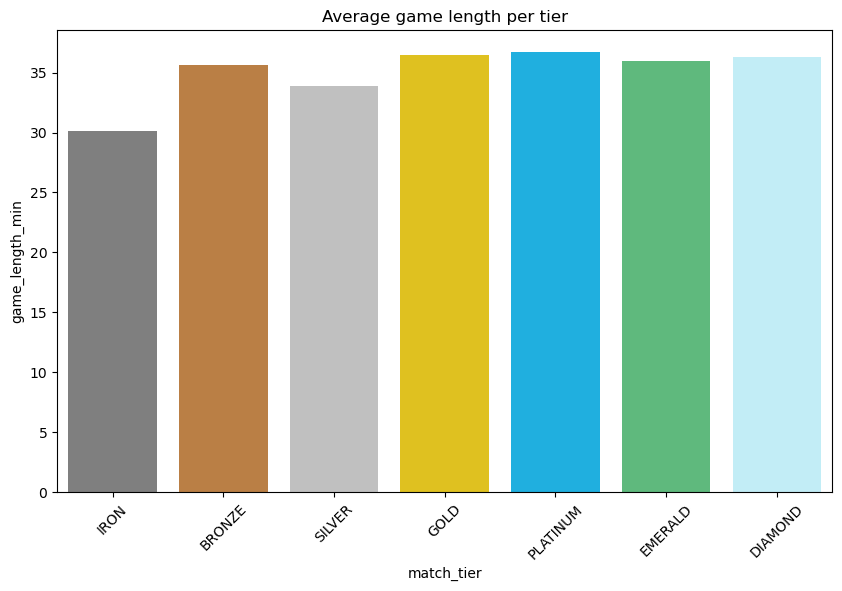

In [204]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_game_length_per_tier,
    x='match_tier',
    y='game_length_min',
    hue='match_tier',
    palette=tier_colors,  
    dodge=False  
)

plt.title('Average game length per tier')
plt.xticks(rotation=45)
plt.show()


In [64]:
df_players_merged = df_players.merge(
    df[['match_id', 'game_length_min']],
    on='match_id',
    how='inner'
)

df_players_merged.dropna(subset=['tier', 'division'], inplace=True)
df_players_merged.head()

,puuid,match_id,placement,level,gold_left,last_round,players_eliminated,time_eliminated,total_damage,companion_id,tier,division,leaguePoints,wins,losses,tier_rank,game_length_min
0,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,EUN1_3778549380,3,9,1,38,0,2177.756592,157,d401983f-04c9-4809-a1f4-d995a9ab6091,BRONZE,III,93,3,2,1.0,38.06228
1,Ud8sd5s8jE_5bpv4rpb0-BRvayXhHJXKbi0eB1jue8iJxO...,EUN1_3778549380,5,8,30,33,0,1909.064697,68,05e285f5-7d09-4126-9643-da31b1bd2193,BRONZE,II,84,8,15,1.0,38.06228
2,DdLDFxWyhuQTyuZMhQJaL4ZWS5ymGEa0BTgIvXXYS9u53x...,EUN1_3778549380,2,9,1,40,2,2270.521240,184,96c29152-c710-4f05-85c0-32eb73bef7c0,GOLD,IV,76,30,33,3.0,38.06228
3,r6sJI0-vHg3NbXZ5rv92BM342jeKGm2oFpIzNQUAneQkic...,EUN1_3778549380,6,7,3,28,0,1647.791016,65,f152e2a3-6751-42e5-a911-ef029d5a8bff,SILVER,III,86,20,29,2.0,38.06228
4,x0Ze-ORBYyEFKumY3rTDvSORTwnZTM9xnXUECY3Thm3hWV...,EUN1_3778549380,1,10,4,40,3,2270.521240,187,27f5bf5a-7183-4efa-b065-86ff9b8c0fb1,PLATINUM,II,57,33,19,4.0,38.06228


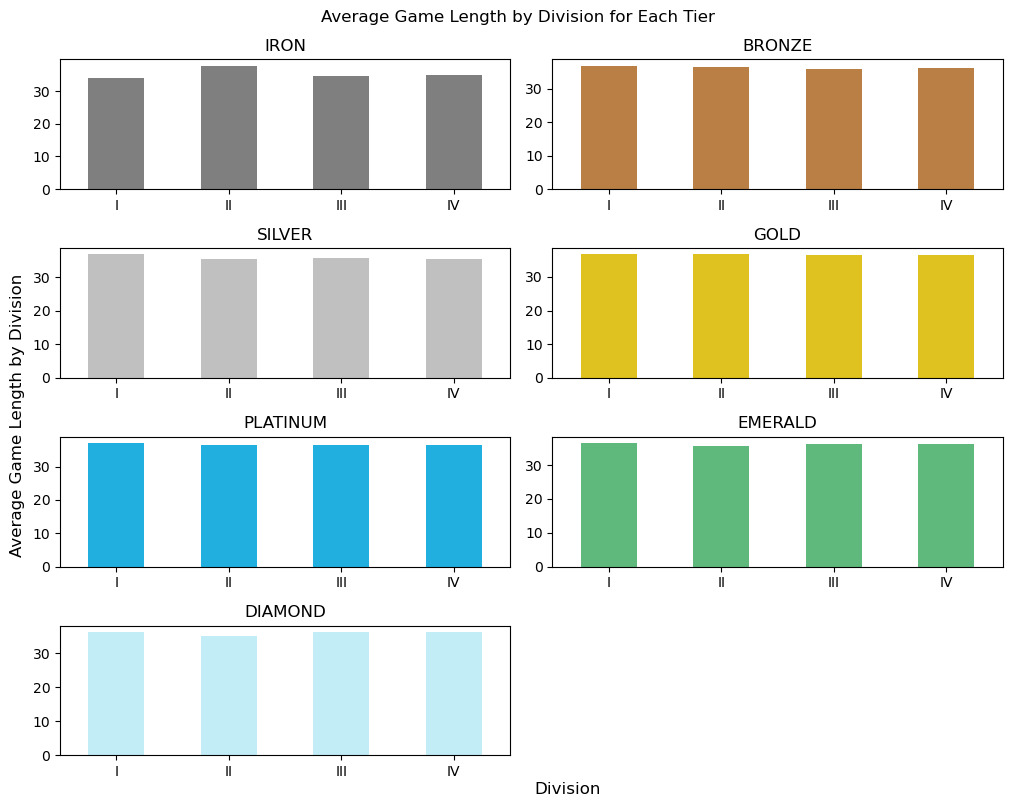

In [97]:
fig, ax = plt.subplots(4, 2, figsize=(10,8))
fig.suptitle('Average Game Length by Division for Each Tier')

axes_flat = ax.flatten()

for i, tier in enumerate(tier_order):
    tier_players = df_players_merged[df_players_merged['tier'] == tier]
    tier_division_stats = tier_players.groupby('division')['game_length_min'].mean().reset_index()
    tier_division_stats = tier_division_stats.sort_values(by='division')
    
    sns.barplot(tier_division_stats, x='division', y='game_length_min', ax=axes_flat[i], width=0.5, color=tier_colors[tier])
    axes_flat[i].set_title(tier)
    axes_flat[i].set_ylabel('')
    axes_flat[i].set_xlabel('')

fig.delaxes(axes_flat[-1])
fig.text(0.0, 0.3, 'Average Game Length by Division', ha='center', rotation='vertical', fontsize=12)
fig.text(0.55, 0.00, 'Division', ha='center', fontsize=12)
plt.tight_layout() 
plt.show()

As expected games in every division has similar game length. 

## Game time analysis

In [192]:
# time when game was played 
df_game_time = df.merge(match_tiers_df, on='match_id', how='right')
df_game_time.head()

,match_id,game_datetime,game_length,map_id,tft_set_number,datetime,game_length_min,match_tier
0,EUN1_3778549380,1746732492440,2283.736816,22,14,2025-05-08 19:28:12.440,38.062280,BRONZE
1,EUN1_3785215189,1748180709057,1945.732422,22,14,2025-05-25 13:45:09.057,32.428874,BRONZE
2,EUN1_3782117290,1747503305415,1255.649292,22,14,2025-05-17 17:35:05.415,20.927488,IRON
3,EUN1_3783607953,1747829872691,2180.702881,22,14,2025-05-21 12:17:52.691,36.345048,BRONZE
4,EUN1_3774992073,1745959458563,2183.478027,22,14,2025-04-29 20:44:18.563,36.391300,GOLD


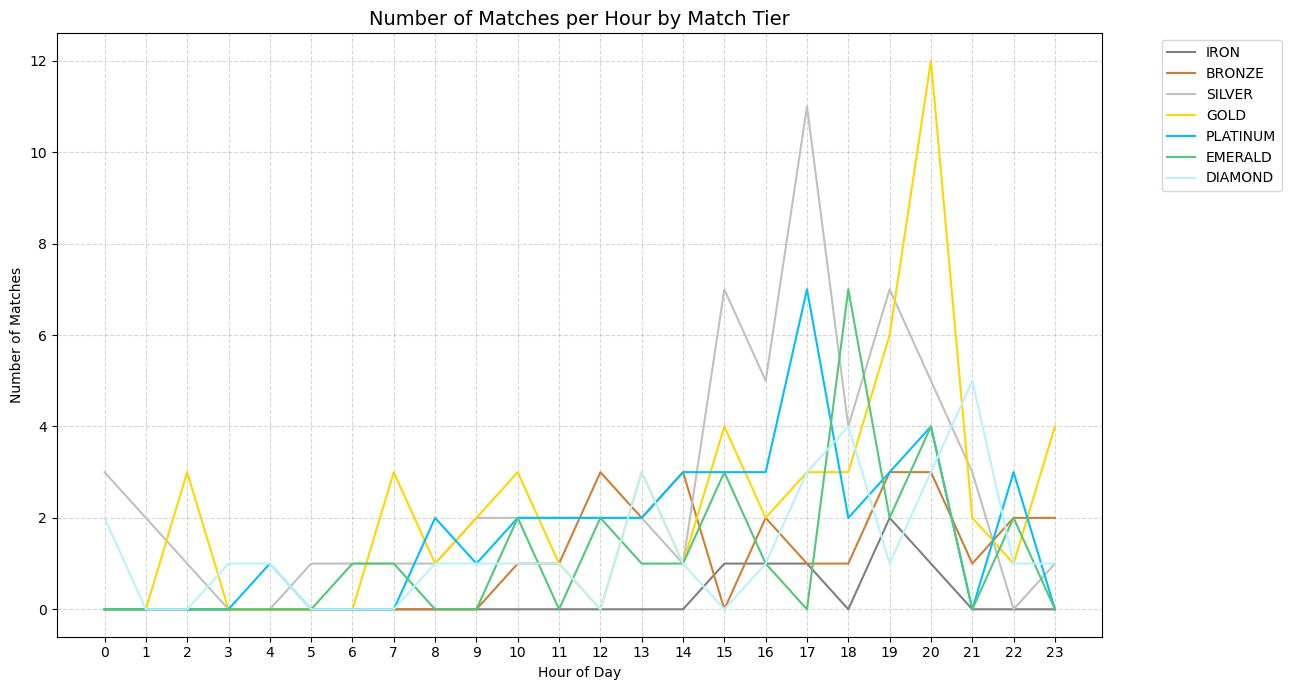

In [213]:
df_game_time['hour'] = df_game_time['datetime'].dt.hour

hourly_tier_counts = df_game_time.groupby(['hour', 'match_tier']).size().reset_index(name='count')

# using pivot to have tiers as a columns and hour as an index
# we want to have hours as rows and as columns tiers, where values are number of matches !! 
hourly_tier_pivot = hourly_tier_counts.pivot(index='hour', columns='match_tier', values='count').fillna(0) # fillna(0) - 0 if in this hour 0 matches

plt.figure(figsize=(13, 7))
for tier in tier_order:
    plt.plot(hourly_tier_pivot.index, hourly_tier_pivot[tier], label=tier, color=tier_colors[tier])

plt.title('Number of Matches per Hour by Match Tier', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Matches')
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

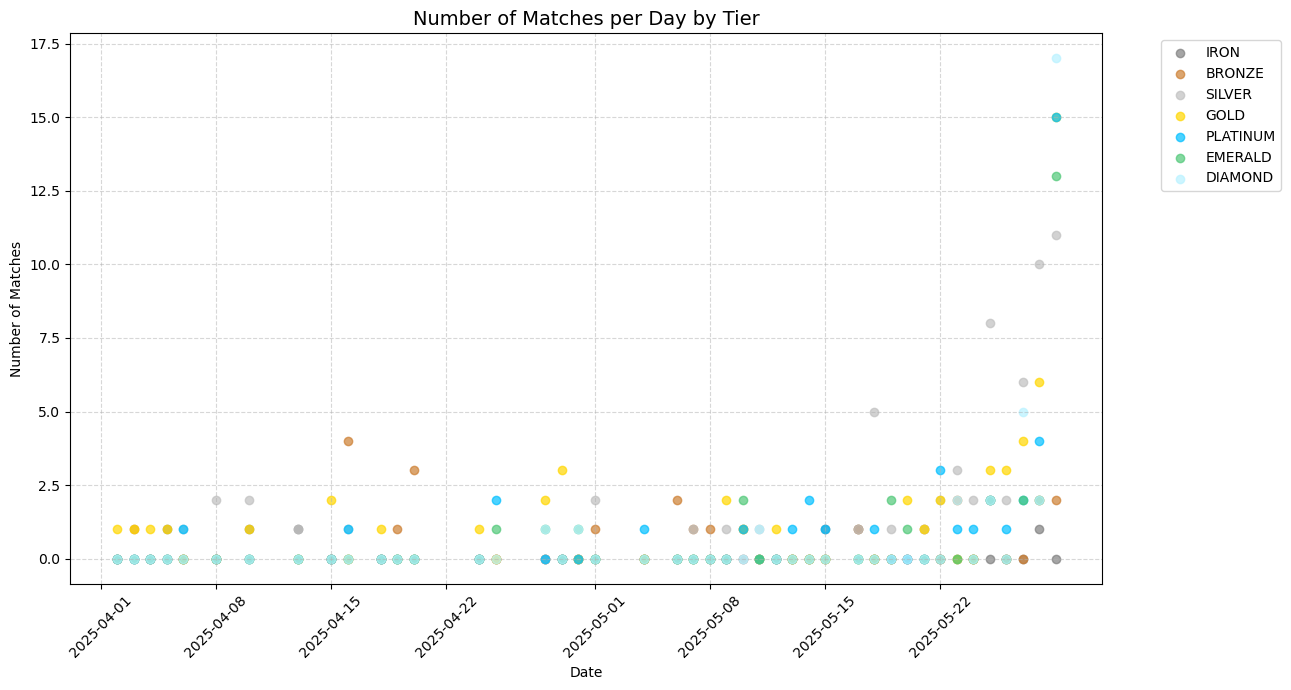

In [214]:
df_game_time['date'] = df_game_time['datetime'].dt.date

daily_matches = df_game_time.groupby(['date', 'match_tier']).size().reset_index(name='count')
daily_matches_pivot = daily_matches.pivot(index='date', columns='match_tier', values='count').fillna(0)

plt.figure(figsize=(13, 7))
for tier in tier_order:
    plt.scatter(daily_matches_pivot.index, daily_matches_pivot[tier], label=tier, color=tier_colors[tier], alpha=0.7)

plt.title('Number of Matches per Day by Tier', loc='center', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Matches')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

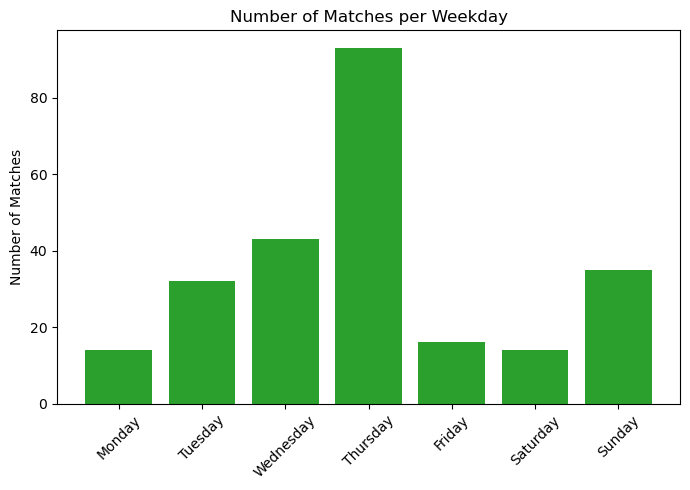

In [218]:
df_game_time['weekday'] = df_game_time['datetime'].dt.day_name()

# reindex is used to set real week order, ad reset_index() allows us to create a dataframe we need
matches_per_weekday = df_game_time.groupby('weekday').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index(name='match_count')

plt.figure(figsize=(7,5))
plt.bar(matches_per_weekday['weekday'], matches_per_weekday['match_count'], color="#2ca02c")  

plt.title('Number of Matches per Weekday')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Winners and losers info 

In [98]:
division_hierarchy = {
    "IV": 0,
    "III": 1,
    "II": 2,
    "I": 3
}

In [99]:
df_players_merged['tier_rank'] = df_players_merged['tier'].map(tier_hierarchy)
df_players_merged['division_rank'] = df_players_merged['division'].map(division_hierarchy)

In [100]:
# if players with the highest rank wins we return it 
def get_highest_rank_player(match_df):
    max_tier = match_df['tier_rank'].max()
    candidates = match_df[match_df['tier_rank'] == max_tier]

    max_division = candidates['division_rank'].max()
    best_players = candidates[candidates['division_rank'] == max_division]

    return int((best_players['placement'] == 1).any())

In [103]:
match_groups = df_players_merged.groupby('match_id')
wins_by_highest_rank = match_groups.apply(get_highest_rank_player, include_groups=False)

In [108]:
wins_df = wins_by_highest_rank.reset_index() # to reset indexes now we have values from 0,1, ... 
wins_df.columns = ['match_id', 'highest_rank_won']

In [113]:
total_matches = len(wins_df)
wins_by_highest = wins_df['highest_rank_won'].sum()
losses_by_highest = total_matches - wins_by_highest

win_percentage = (wins_by_highest / total_matches) * 100
loss_percentage = (losses_by_highest / total_matches) * 100

print(f"All matches: {total_matches}")
print(f'Wins by highest rank: {win_percentage} %')
print(f'Losses by highest rank: {loss_percentage} %')

All matches: 247
Wins by highest rank: 27.125506072874494 %
Losses by highest rank: 72.8744939271255 %


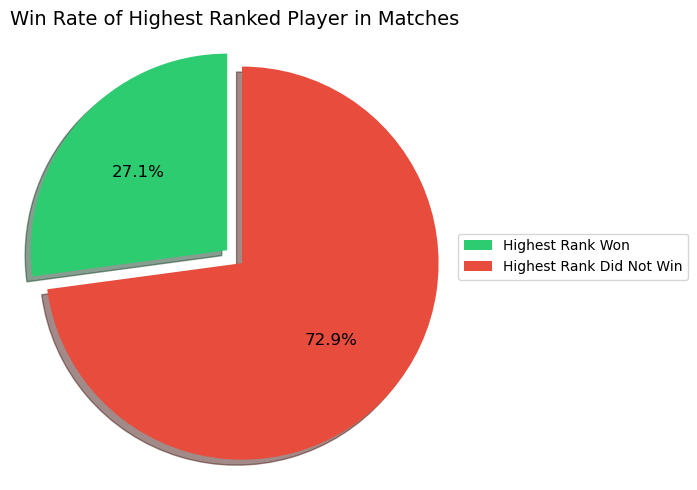

In [174]:
labels = ['Highest Rank Won', 'Highest Rank Did Not Win']
sizes = [wins_by_highest, losses_by_highest]
explode = (0.0, 0.1)

plt.figure(figsize=(7, 5))
plt.pie(
    sizes,
    autopct='%1.1f%%',
    explode=explode,
    startangle=90,
    textprops={'fontsize': 12},
    colors=('#2ecc71', '#e74c3c'), 
    shadow=True, 
)

plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Win Rate of Highest Ranked Player in Matches', fontsize=14)
plt.axis('equal')  
plt.tight_layout()
plt.show()


As we can see a probability that the highest rank will win the match is actually really high. 

In [136]:
def get_match_winner_info(match_df):
    winner = match_df[match_df['placement'] == 1].iloc[0]
    winner_tier = winner['tier']
    winner_division = winner['division']
    winner_tier_rank = winner['tier_rank']
    winner_division_rank = winner['division_rank']

    max_tier = match_df['tier_rank'].max()
    max_division = match_df[match_df['tier_rank'] == max_tier]['division_rank'].max()

    min_tier = match_df['tier_rank'].min()
    min_division = match_df[match_df['tier_rank'] == min_tier]['division_rank'].min()

    highest_rank_won = int((winner_tier_rank == max_tier) and (winner_division_rank == max_division))
    lowest_rank_won = int((winner_tier_rank == min_tier) and (winner_division_rank == min_division))

    return pd.Series({
        'winner_tier': winner_tier,
        'winner_division': winner_division,
        'highest_rank_won': highest_rank_won,
        'lowest_rank_won': lowest_rank_won
    })

In [143]:
match_groups = df_players_merged.groupby('match_id')
match_results = match_groups.apply(get_match_winner_info, include_groups=False).reset_index()
match_results = match_results.merge(match_tiers_df, on='match_id')
match_results.head()

,match_id,winner_tier,winner_division,highest_rank_won,lowest_rank_won,match_tier
0,EUN1_3763831518,PLATINUM,IV,1,0,GOLD
1,EUN1_3764074771,SILVER,III,0,0,BRONZE
2,EUN1_3764109602,GOLD,IV,0,0,GOLD
3,EUN1_3764689201,BRONZE,II,0,0,GOLD
4,EUN1_3765222155,PLATINUM,I,1,0,IRON


In [141]:
# wins by the lowest rank 
wins_by_lowest = match_results['lowest_rank_won'].sum()
losses_by_lowest = total_matches - wins_by_lowest

win_percentage = (wins_by_lowest / total_matches) * 100
losses_percentage = (losses_by_lowest / total_matches) * 100

print(f"All matches: {total_matches}")
print(f'Wins by lowest rank: {win_percentage} %')
print(f'Losses by lowest rank: {losses_percentage} %')

All matches: 247
Wins by lowest rank: 16.599190283400812 %
Losses by lowest rank: 83.40080971659918 %


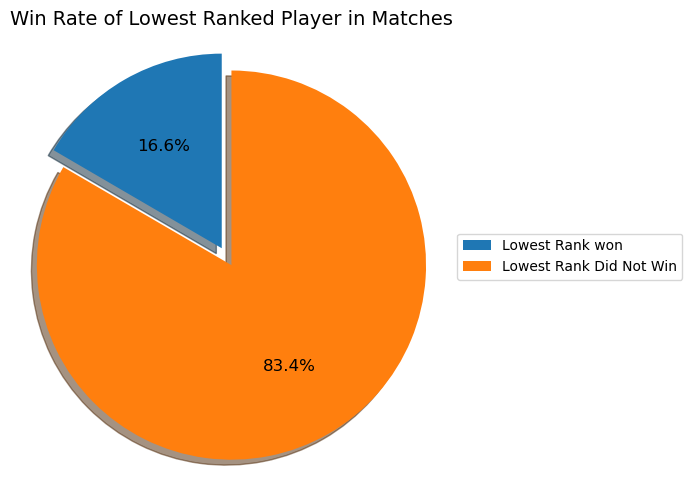

In [173]:
labels = ['Lowest Rank won', 'Lowest Rank Did Not Win']
sizes = [wins_by_lowest, losses_by_lowest]
explode = (0.0, 0.1)

plt.figure(figsize=(7, 5))
plt.pie(
    sizes,
    autopct='%1.1f%%',
    explode=explode,
    startangle=90,
    textprops={'fontsize': 12},
    shadow=True, 
)

plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Win Rate of Lowest Ranked Player in Matches', fontsize=14)
plt.axis('equal')  
plt.tight_layout()

In [145]:
# is winner from the higher, lower or equal tier 
match_results['winner_tier_rank'] = match_results['winner_tier'].map(tier_hierarchy)
match_results['match_tier_rank'] = match_results['match_tier'].map(tier_hierarchy)

In [146]:
def compare_win_to_tier(result):
    if result['winner_tier_rank'] < result['match_tier_rank']:
        return "Lower"
    if result['winner_tier_rank'] > result['match_tier_rank']:
        return "Higher"
    else:
        return "Equal"

In [161]:
match_results['winner_vs_match_tier'] = match_results.apply(compare_win_to_tier, axis=1)

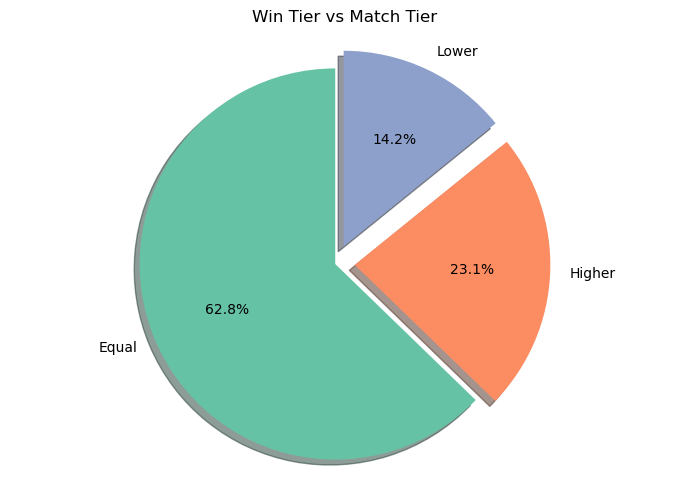

In [172]:
counts = match_results['winner_vs_match_tier'].value_counts()
explode = (0.0, 0.1, 0.1)

plt.figure(figsize=(7, 5))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    explode=explode,
    startangle=90,
    colors=['#66c2a5', '#fc8d62', '#8da0cb'],
    shadow=True
)

plt.title('Win Tier vs Match Tier')
plt.axis('equal')  
plt.tight_layout()
plt.show()

As expected, if there is a player with a higher rank than the average in a match, their chances of winning are greater compared to those with lower ranks.

In this plot, the win rates for higher and equal-ranked players might be slightly overestimated. This is because, in cases where the ranks are evenly split (e.g., 3 Gold and 3 Silver players), the average match tier may be considered Silver. Therefore, if a Gold player wins, it's technically counted as a win against a lower-tier field — even though the competition was more balanced. Still, within the context of this analysis, such a winner is classified as having defeated an "equal" or "lower" tier. 

In [185]:
win_counts = match_results.groupby(['match_tier', 'winner_tier']).size().reset_index(name='count')
win_counts['percentage'] = win_counts.groupby('match_tier')['count'].transform(lambda x: x / x.sum() * 100)
win_pivot = win_counts.pivot(index='match_tier', columns='winner_tier', values='percentage').fillna(0)
win_pivot = win_pivot.reindex(tier_order)
win_pivot = win_pivot[tier_order]

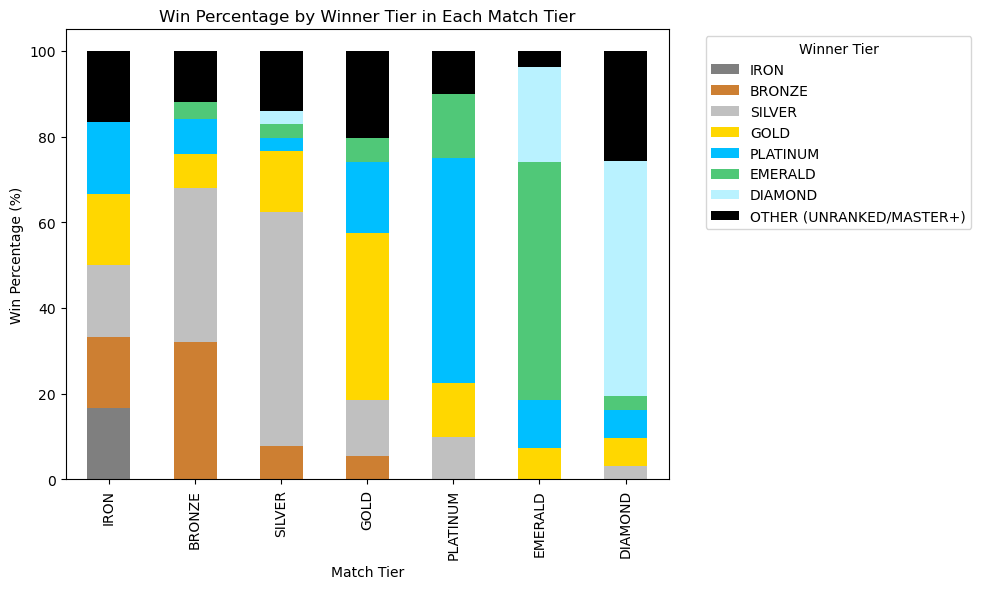

In [190]:
other_tiers_label = "OTHER (UNRANKED/MASTER+)" 
other_color = "Black" 
win_pivot[other_tiers_label] = 100 - win_pivot[tier_order].sum(axis=1)

colors = [tier_colors[tier] for tier in tier_order] + [other_color]

win_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Win Percentage by Winner Tier in Each Match Tier')
plt.xlabel('Match Tier')
plt.ylabel('Win Percentage (%)')

plt.legend(title='Winner Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()